# Power Analysis for the DR CI for Comparing Abstaining Classifiers under MAR

Experiment 2.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os.path
from collections import OrderedDict

from tqdm.notebook import tqdm, trange
from joblib import Parallel, delayed
import time
import itertools as it

import comparecast as cc
import comparecast_causal as c3

[MLENS] backend: threading


In [2]:
RANDOM_SEED = 1234

rng = np.random.default_rng(RANDOM_SEED)

Configurations for evaluation:

In [3]:
ALPHA = 0.05
SCORING_RULE = "zero_one"
EPSILON = 0.2
CLIP_PI = EPSILON   # how much to clip large values of estimated abstention probability
N_TRIALS = 1000     # repetitions  
N_JOBS = -1         # number of CPU cores for parallel processing
MIXED_EST = False   # use mixed estimation

In [4]:
PLOTS_DIR = "./plots/binary_mar/experiment2{}/{}/eps{:g}".format(
    "_mixed" if MIXED_EST else "", SCORING_RULE, EPSILON,
)
os.makedirs(PLOTS_DIR, exist_ok=True)

FONT = "Liberation Serif"  # for servers & colab; if not use "DejaVu Serif"
cc.set_theme(style="whitegrid", font=FONT)

## Data

Generate synthetic predictions and abstentions.

In [21]:
n = 2000
epsilon = EPSILON        # positivity level
threshold = 0.2          # how close to border do you switch to abstention?
noise_level = 0.15       # noise level of the true decision boundary
power_mu = 0.2           # how much the decision boundery gets shifted for B

data = c3.data_utils.abstaining_classifiers.generate_binary_mar(
    n=n, 
    epsilon=epsilon,
    threshold=threshold,
    noise_level=noise_level,
    is_power_analysis=True,
    power_mu=power_mu,
    rng=rng,
    for_plotting=True,
)
data

,$X_0$,$X_1$,$Y$,Classifier,$P$,$\hat{Y}$,Abstain,Correct
0,0.976700,0.380196,1,A,0.588289,1,No,Yes
1,0.923246,0.261692,1,A,0.546103,1,Yes,Yes
2,0.319097,0.118091,0,A,0.362897,0,Yes,Yes
3,0.241766,0.318534,0,A,0.391813,0,No,Yes
4,0.964079,0.263650,1,A,0.556687,1,No,Yes
...,...,...,...,...,...,...,...,...
3995,0.447085,0.572443,1,B,0.455004,0,Yes,No
3996,0.785321,0.039024,0,B,0.407175,0,No,Yes
3997,0.484321,0.654514,1,B,0.484713,0,Yes,No
3998,0.219913,0.875807,1,B,0.473954,0,Yes,No


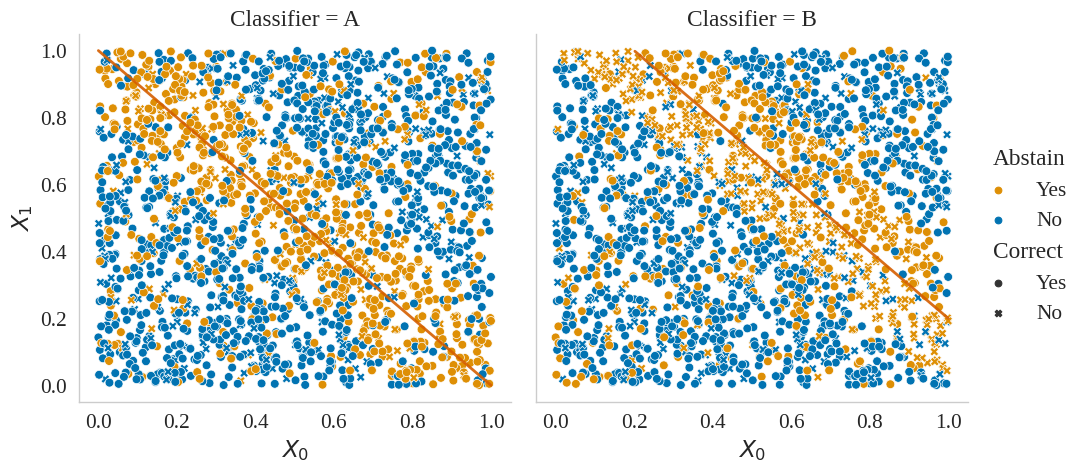

In [22]:
fg = sns.relplot(
    x=r"$X_0$",
    y=r"$X_1$",
    style="Correct",
    col="Classifier",
    hue="Abstain",
    style_order=["Yes", "No"],
    hue_order=["Yes", "No"],
    palette=[cc.get_color_by_index(1), cc.get_color_by_index(0)],
    data=data,
    s=40,
)
for ax in fg.axes[0]:
    ax.grid()

x0 = np.linspace(0, 1, 100)
# A boundary
x1_a = 1 - x0
fg.axes[0, 0].plot(x0, x1_a, linewidth=2, alpha=0.9, color=cc.get_color_by_index(3))

# B boundary
x1_b = 1 + power_mu - x0
fg.axes[0, 1].plot(x0[x1_b <= 1.0], x1_b[x1_b <= 1.0], linewidth=2, alpha=0.9, color=cc.get_color_by_index(3))

fg.savefig(os.path.join(PLOTS_DIR, "classifiers.pdf"))
None

## `DREvalAbst` for comparison

Score differences for each value of $\mu$:

In [7]:
mus = np.linspace(0, 0.5, 11)
print(mus)

for mu in mus:
    X, y, predictions, abstentions, predictions_b, abstentions_b = \
        c3.data_utils.abstaining_classifiers.generate_binary_mar(
            n=n, 
            epsilon=epsilon,
            threshold=threshold,
            noise_level=noise_level,
            is_power_analysis=True,
            power_mu=mu,
            rng=rng,
            return_np_arrays=True,
        )

    # compute scores
    scores_a = c3.compute_scores(predictions, abstentions, y, SCORING_RULE)
    scores_b = c3.compute_scores(predictions_b, abstentions_b, y, SCORING_RULE)
    print("-" * 40)
    print("mu: {:.1g}".format(mu))
    print("oracle CF score difference: {:.3f}".format(
        scores_a["oracle_cf_score"] - scores_b["oracle_cf_score"]))
    print("-" * 40)
    for name, scores in [["A", scores_a], ["B", scores_b]]:
        print(f"[Classifier {name}]")
        print("selective score: {:.3f}".format(scores["selective_score"]))
        print("coverage: {:.3f}".format(scores["coverage"]))
        print("(oracle) counterfactual score: {:.3f}".format(scores["oracle_cf_score"]))

[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5 ]
----------------------------------------
mu: 0
oracle CF score difference: 0.000
----------------------------------------
[Classifier A]
selective score: 0.853
coverage: 0.590
(oracle) counterfactual score: 0.852
[Classifier B]
selective score: 0.855
coverage: 0.604
(oracle) counterfactual score: 0.852
----------------------------------------
mu: 0.05
oracle CF score difference: 0.044
----------------------------------------
[Classifier A]
selective score: 0.845
coverage: 0.586
(oracle) counterfactual score: 0.847
[Classifier B]
selective score: 0.811
coverage: 0.591
(oracle) counterfactual score: 0.802
----------------------------------------
mu: 0.1
oracle CF score difference: 0.069
----------------------------------------
[Classifier A]
selective score: 0.867
coverage: 0.582
(oracle) counterfactual score: 0.860
[Classifier B]
selective score: 0.833
coverage: 0.585
(oracle) counterfactual score: 0.791
--------------------------

In [8]:
def run_experiment(X, y, predictions, abstentions, predictions_b, abstentions_b,
                   estimator, learner, alpha, scoring_rule, clip_pi, rng, verbose=False):
    """Compute DR CI and calculate diagnostics."""

    # compute scores
    scores_a = c3.compute_scores(predictions, abstentions, y, scoring_rule)
    scores_b = c3.compute_scores(predictions_b, abstentions_b, y, scoring_rule)

    if verbose:
        print("{:g}% DR CI for CF score difference [estimator: {:s}, learner: {:s}]".format(
            100 * (1 - ALPHA), estimator, learner,
        ))

    # compute CI
    drci_obj = c3.DREvalAbst(
        inputs=X, 
        labels=y, 
        predictions=np.array([1 - predictions, predictions]).T,
        abstentions=abstentions,
        predictions_b=np.array([1 - predictions_b, predictions_b]).T,
        abstentions_b=abstentions_b,
        scoring_rule=SCORING_RULE,
        pi_fn=c3.get_learner("c", learner),
        mu0_fn=c3.get_learner("r", learner),
        clip_pi=clip_pi,
        estimator=estimator,
        mixed_estimation=MIXED_EST,
        mixed_coef=None,  # find optimal one
        cross_fit=True,
        alpha=ALPHA,
        rng=rng,
        verbose=verbose,
    )
    ci = drci_obj.compute_ci()
    oracle_cf_diff = scores_a["oracle_cf_score"] - scores_b["oracle_cf_score"]
    if verbose:
        print("Cross-fit estimate: {:.5f}".format(drci_obj.estimate.mean()))
        print("Asymptotic CI: ({:.5f}, {:.5f})".format(ci[0], ci[1]))
        print("CI width: {:.5f}".format(ci[1] - ci[0]))
        print("Contains oracle CF score:", ci[0] <= oracle_cf_diff <= ci[1])
        print("Rejection (for H0: diff=0):", (ci[0] > 0) or (ci[1] < 0))
        print("-" * 40)

    # returns a summary dict
    summary = dict(
        alpha=alpha,
        scoring_rule=scoring_rule,
        estimator=estimator,
        learner=learner,
        oracle_cf_diff=oracle_cf_diff,
        estimate=(ci[0] + ci[1]) / 2,
        ci=ci,
        width=ci[1] - ci[0],
        miscovered=(oracle_cf_diff < ci[0]) or (ci[1] < oracle_cf_diff),
        rejection=(ci[0] > 0) or (ci[1] < 0),
    )
    return summary

Single runs:

In [9]:
estimator = "DR"
learners = ["Linear", "RandomForest", "SuperLearner"]
for learner in learners:
    summary = run_experiment(
        X, y, predictions, abstentions, predictions_b, abstentions_b,
        estimator=estimator, learner=learner, 
        alpha=ALPHA, scoring_rule=SCORING_RULE, clip_pi=CLIP_PI, rng=rng,
        verbose=True,
    )

95% DR CI for CF score difference [estimator: DR, learner: Linear]
pi [split=0] evaluation: accuracy 0.58871
mu0 [split=0] evaluation: MSE 0.12093
pi_b [split=0] evaluation: accuracy 0.71169
mu0_b [split=0] evaluation: MSE 0.21195
pi [split=1] evaluation: accuracy 0.59325
mu0 [split=1] evaluation: MSE 0.14076
pi_b [split=1] evaluation: accuracy 0.74504
mu0_b [split=1] evaluation: MSE 0.22321
Cross-fit estimate: 0.26253
Asymptotic CI: (0.23018, 0.29488)
CI width: 0.06470
Contains oracle CF score: True
Rejection (for H0: diff=0): True
----------------------------------------
95% DR CI for CF score difference [estimator: DR, learner: RandomForest]
pi [split=0] evaluation: accuracy 0.75732
mu0 [split=0] evaluation: MSE 0.16080
pi_b [split=0] evaluation: accuracy 0.75354
mu0_b [split=0] evaluation: MSE 0.17378
pi [split=1] evaluation: accuracy 0.75027
mu0 [split=1] evaluation: MSE 0.16484
pi_b [split=1] evaluation: accuracy 0.74708
mu0_b [split=1] evaluation: MSE 0.16529
Cross-fit estimate:

In [10]:
summary

{'alpha': 0.05,
 'scoring_rule': 'zero_one',
 'estimator': 'DR',
 'learner': 'SuperLearner',
 'oracle_cf_diff': 0.2705000000000001,
 'estimate': 0.2696718718583761,
 'ci': array([0.23708565, 0.30225809]),
 'width': 0.06517243947525742,
 'miscovered': False,
 'rejection': True}

## Rejection Rates (Power)

Averaged over `n_trials`.

* Estimator choice: `DR`
* Nuisance function learners: `Linear`, `RandomForest`, `SuperLearner`
* $\mu$: `[0, 0.05, 0.1, 0.15, 0.2, ..., 0.5]`
* $n$: `[200, 400, 800, 1600, 3200]`

In [11]:
# a parallelizable stochastic function (can vary epsilon, estimator, learner)
def compute_power(seed):
    rng = np.random.default_rng(seed)
    data = c3.data_utils.abstaining_classifiers.generate_binary_mar(
        n=n, 
        epsilon=epsilon,
        threshold=threshold,
        noise_level=noise_level,
        is_power_analysis=True,
        power_mu=mu,
        rng=rng,
        return_np_arrays=True,
    )
    summary = run_experiment(
        *data, 
        estimator=estimator, learner=learner, 
        alpha=ALPHA, scoring_rule=SCORING_RULE, clip_pi=CLIP_PI, rng=rng,
        verbose=False,
    )
    return summary["rejection"], summary["miscovered"]

In [ ]:
# parallel RNG (independent seeds; some randomness from individual learner training steps)
use_parallel = True
rng = np.random.default_rng(RANDOM_SEED)
ss = rng.bit_generator._seed_seq
child_states = ss.spawn(N_TRIALS)

summary = OrderedDict({"rejection": dict(), "miscoverage": dict()})
df_rows = []
mus = np.linspace(0, 0.5, 11)
ns = [200, 400, 800, 1600, 3200]

for learner in learners:
    for mu in mus:
        for n in ns:
            t0 = time.time()
            if use_parallel:
                results = Parallel(n_jobs=N_JOBS)(
                        delayed(compute_power)(seed) for seed in child_states
                )
            else:
                results = [compute_power(seed) for seed in range(N_TRIALS)]
            df_rows.extend([{"Estimator": estimator, "Learner": learner, 
                             "Rejection": r, "Miscoverage": mc,
                             "n": n, "mu": mu,}
                            for r, mc in results])
            rejections, miscovs = zip(*results)
            for name, stats in [("rejection", rejections), ("miscoverage", miscovs)]:
                m = np.mean(stats)
                se = np.sqrt(m * (1-m) / len(stats))
                if name == "rejection":
                    print("{} rate [learner: {}, mu: {}, n: {}]: {} +/- {:.3f}".format(
                        name, learner, mu, n, m, se,
                    ))
                summary[name][learner, mu, n] = m, se

            t1 = time.time()
            print("elapsed time (n_jobs={}): {:.2f}s".format(N_JOBS, t1 - t0))

In [13]:
df = pd.DataFrame(df_rows)
df.to_csv(os.path.join(PLOTS_DIR, "power.csv"))
df.rename(columns={"mu": r"$\mu$", "n": r"$n$", 
                   "Rejection": "Rejection Rate",
                   "Miscoverage": "Miscoverage Rate"}, inplace=True)

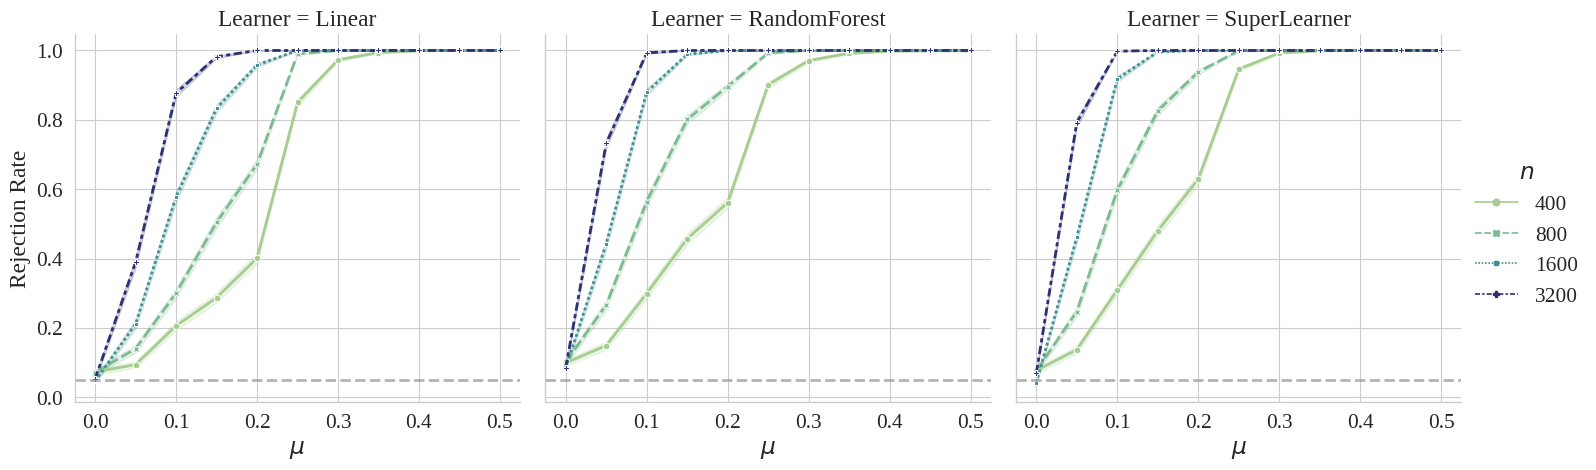

In [19]:
fg = sns.relplot(
    x=r"$\mu$",
    y="Rejection Rate",
    hue=r"$n$",
    style=r"$n$",
    col="Learner",
    kind="line",
    linewidth=2,
    markers=True,
    errorbar="se",
    palette="crest",
    data=df[df[r"$n$"] > 200],
    #height=8,
    #aspect=2,
    # facet_kws={"legend_out": False},
)
for i in range(len(learners)):
    fg.axes[0, i].axhline(y=0.05, alpha=0.7, linewidth=2, linestyle="--",
                          color=cc.get_color_by_index(7))
# sns.move_legend(fg, "center", bbox_to_anchor=(0.45, 0.55))
fg.savefig(os.path.join(PLOTS_DIR, "power.pdf"))